In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def load_images(folder):
    images = {}
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = cv.imread(img_path)
            if img is not None:
                images[filename] = img
    return images

folder_path = 'D:/xuexi/CV/tlights'
images = load_images(folder_path)
print(f"Loaded {len(images)} images from {folder_path}")

Loaded 50 images from D:/xuexi/CV/tlights


In [3]:
images_rgb = {}
for key, img in images.items():
    images_rgb[key] = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [4]:
images_hsv = {}
for key, img in images_rgb.items():
    images_hsv[key] = cv.cvtColor(img, cv.COLOR_RGB2HSV)

Consider the three channels of HSV to improve the accuracy of discrimination

C:\Users\ywd\AppData\Local\Temp\ipykernel_2600\3757097015.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


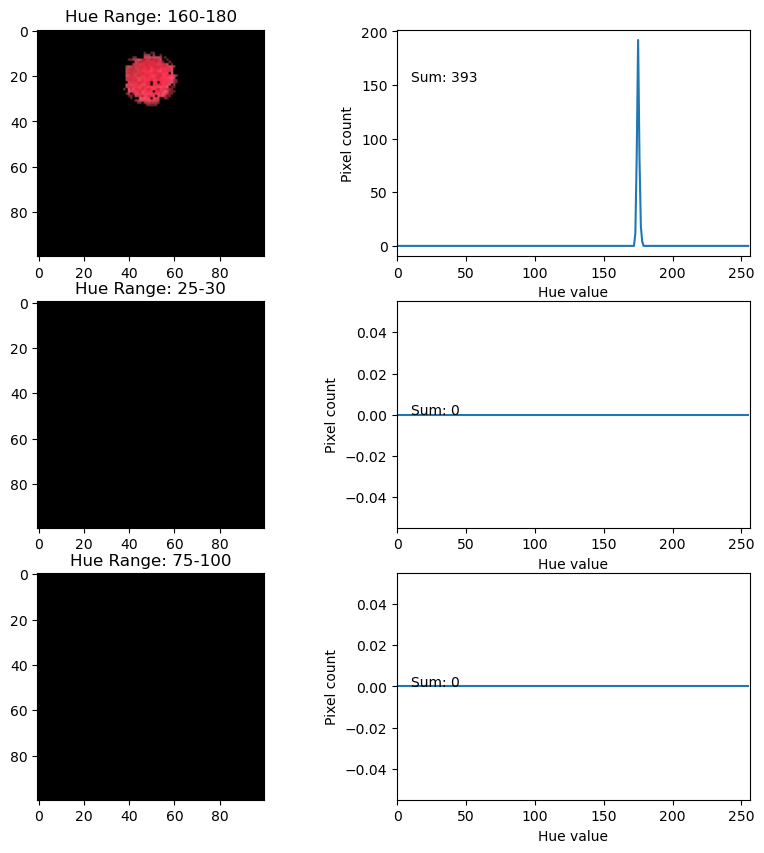

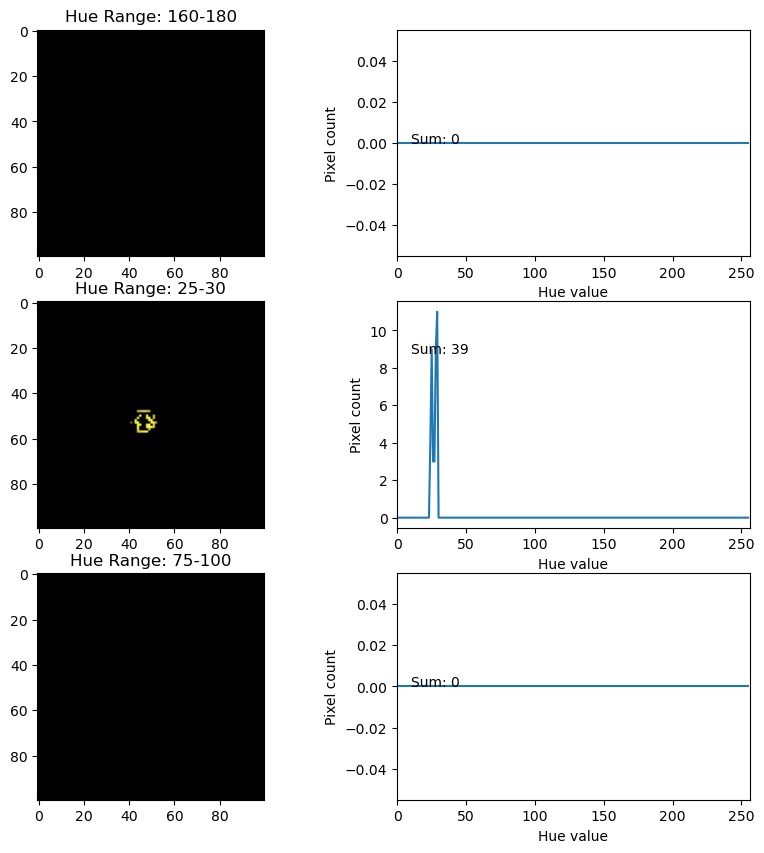

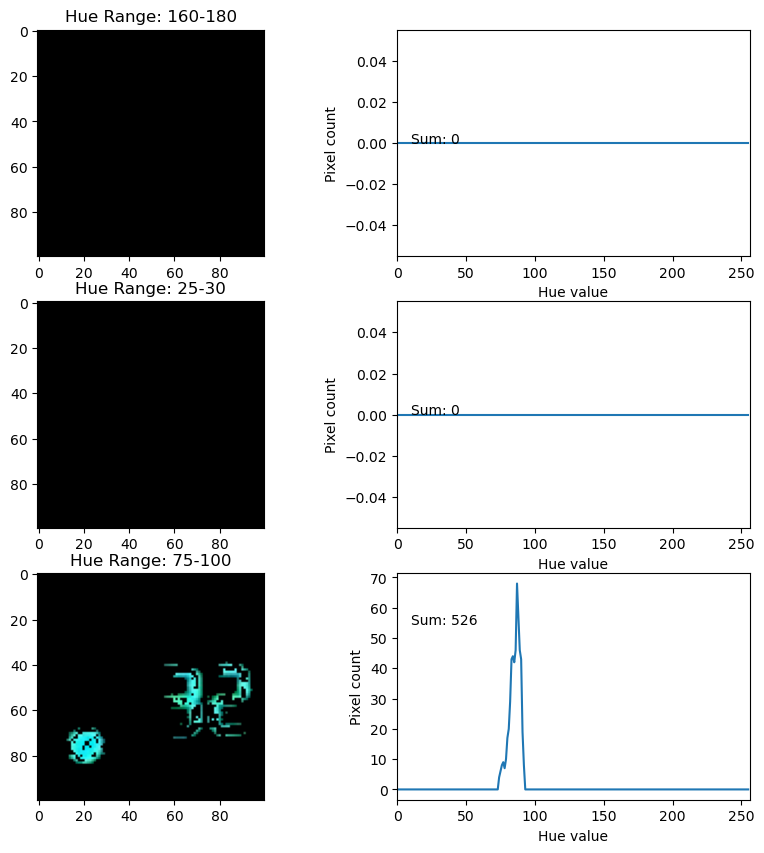

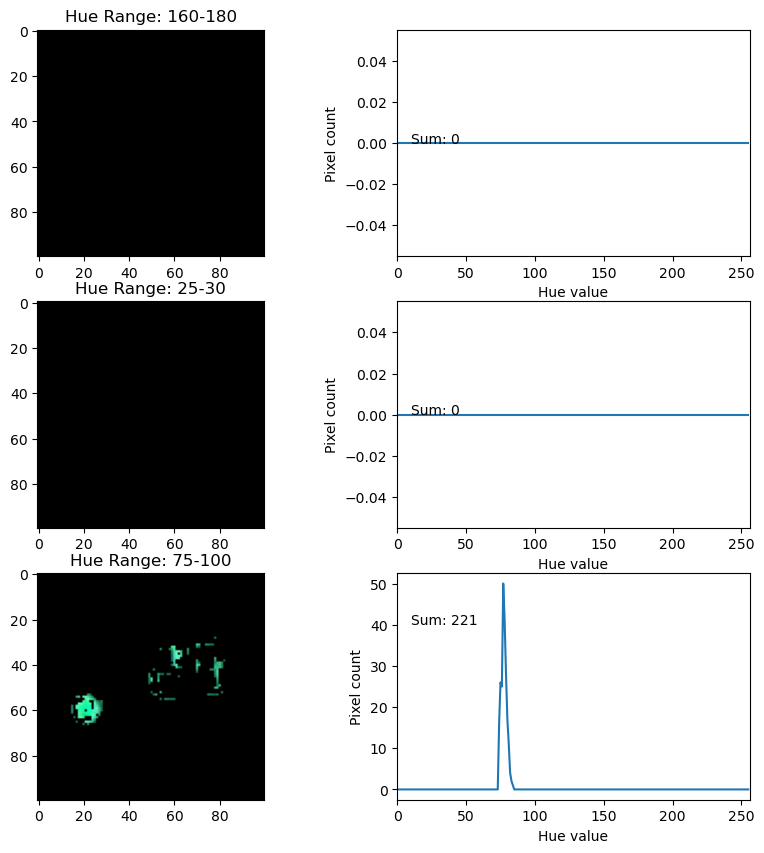

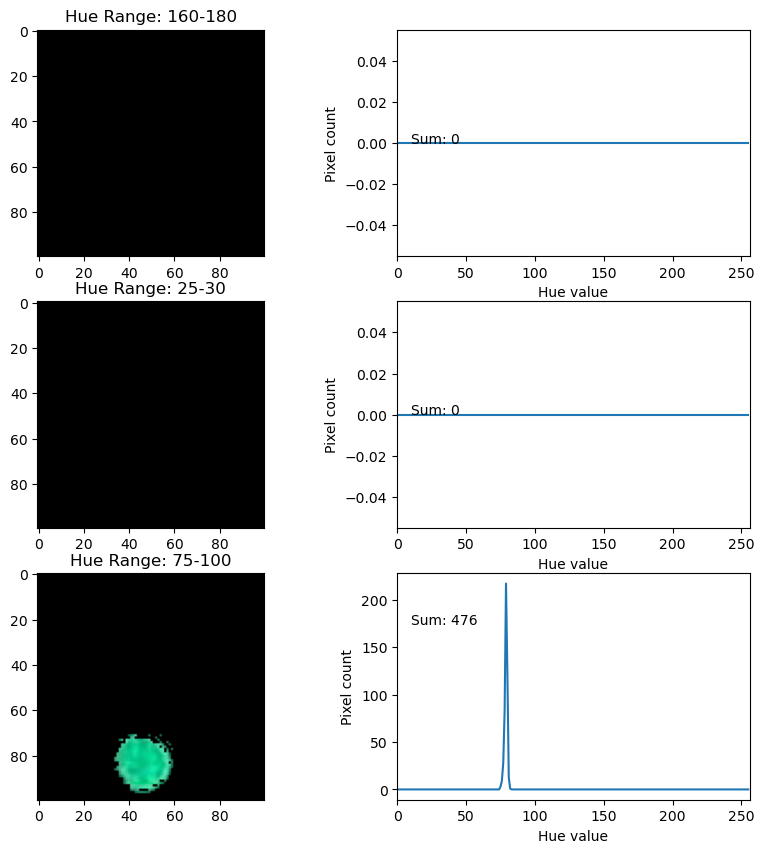

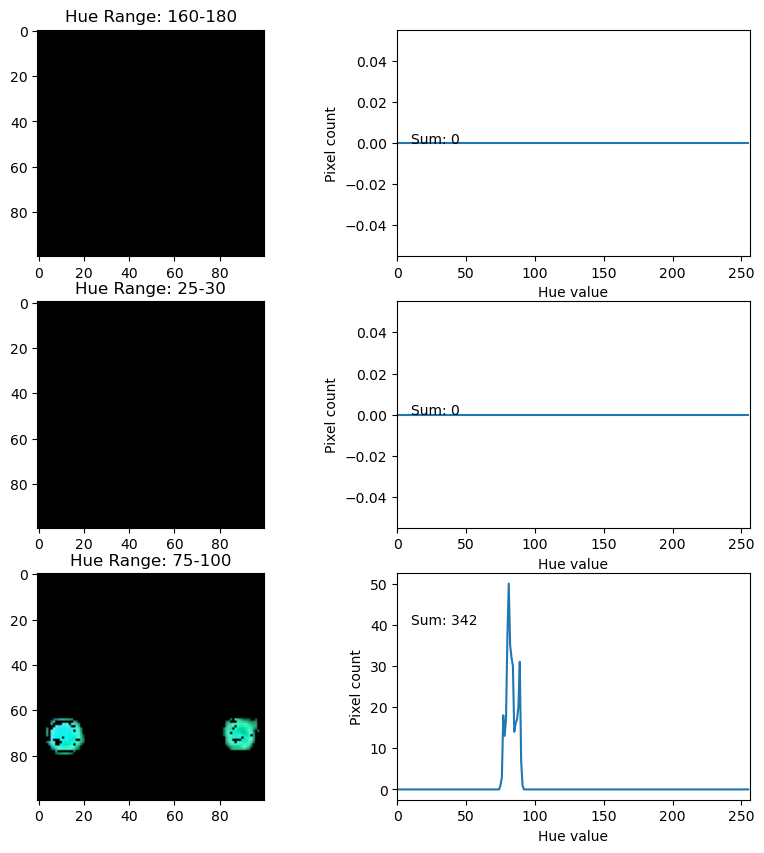

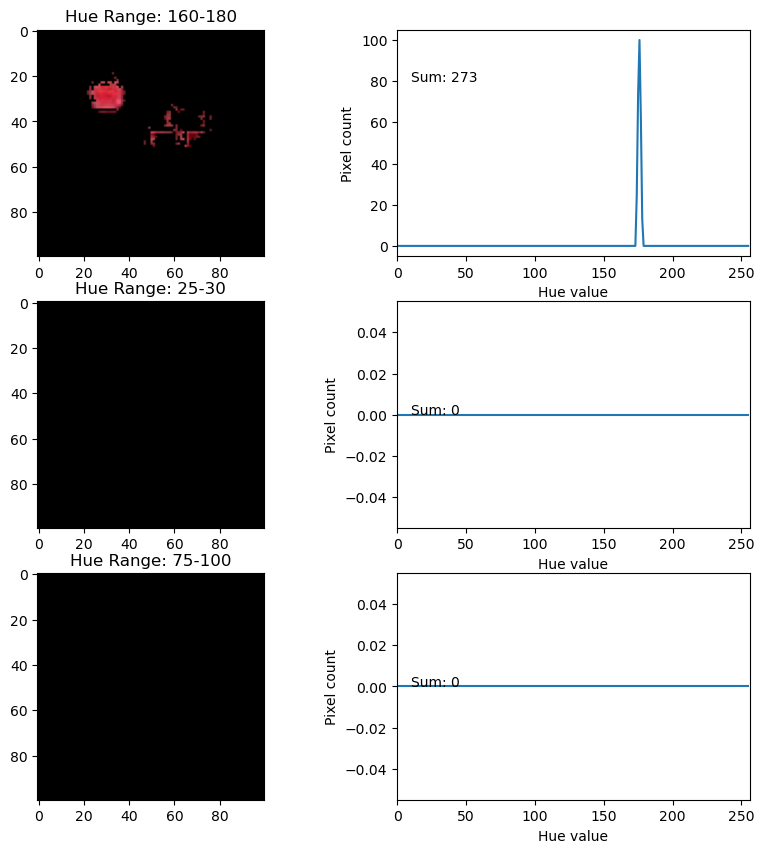

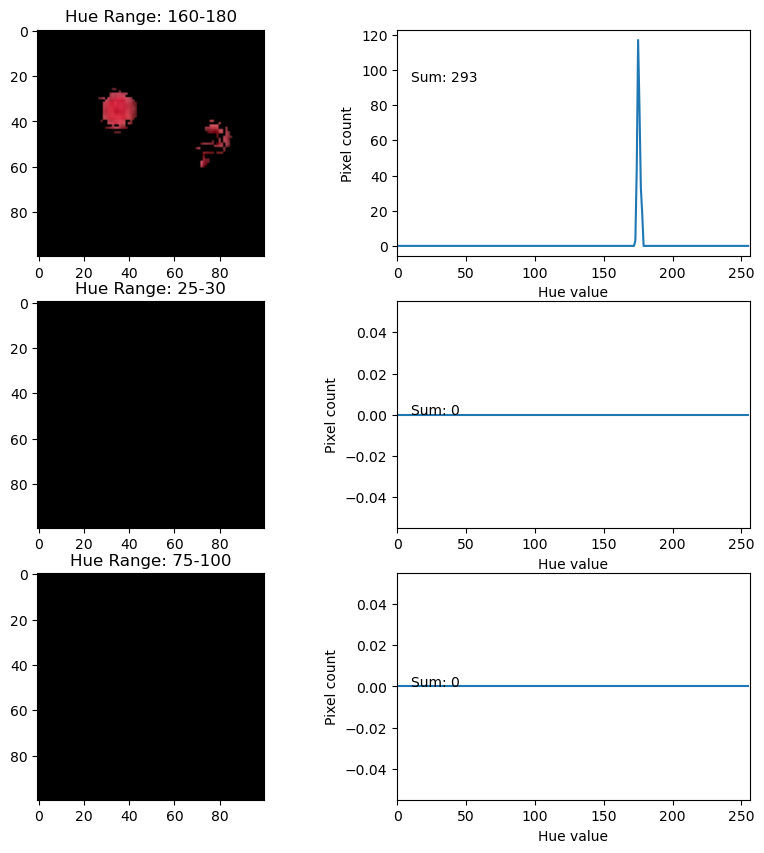

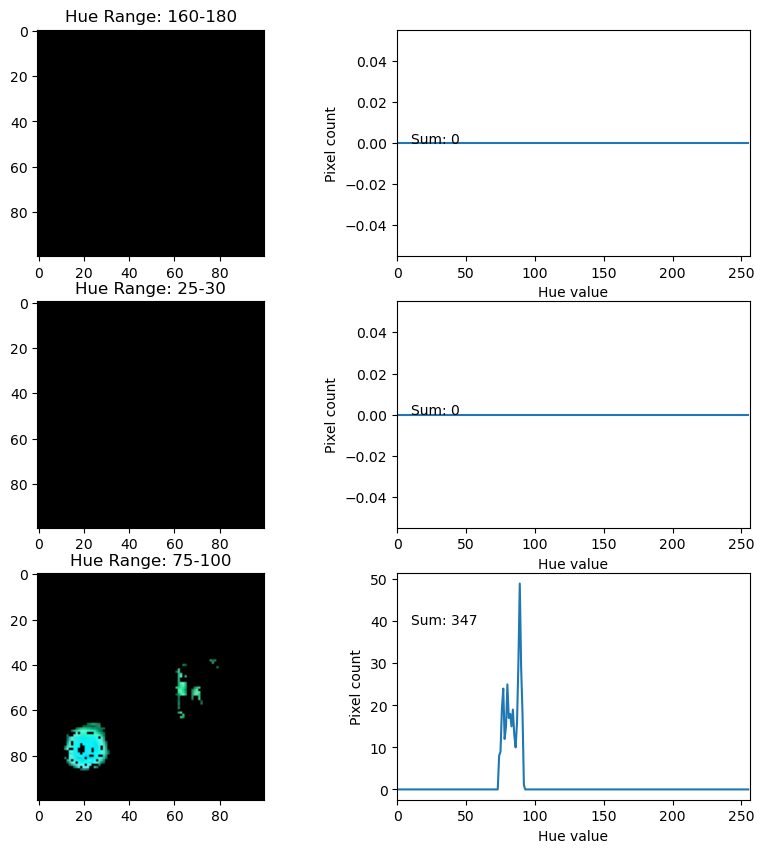

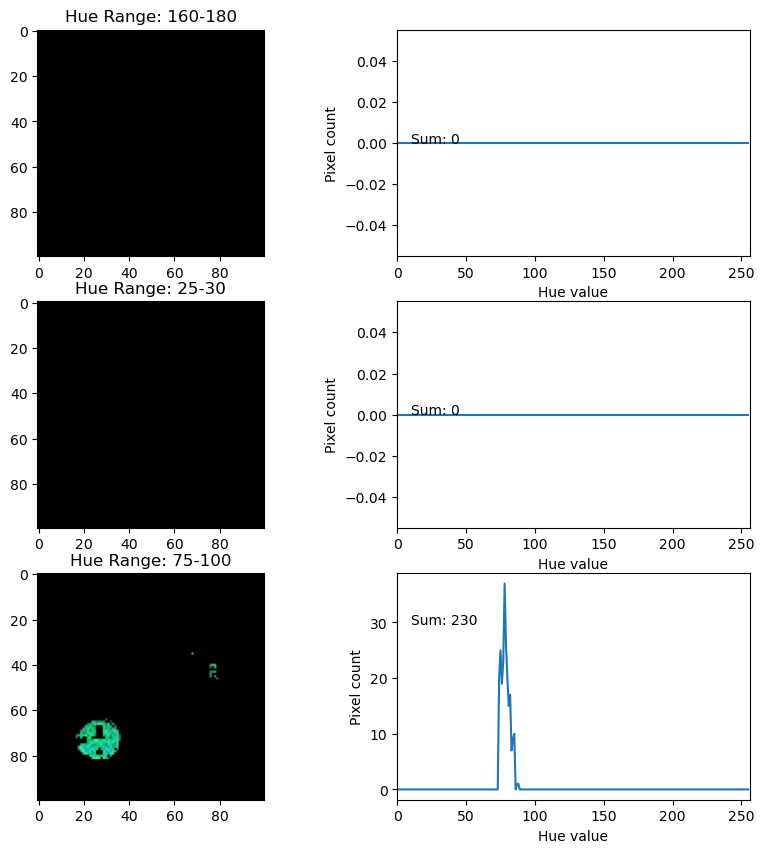

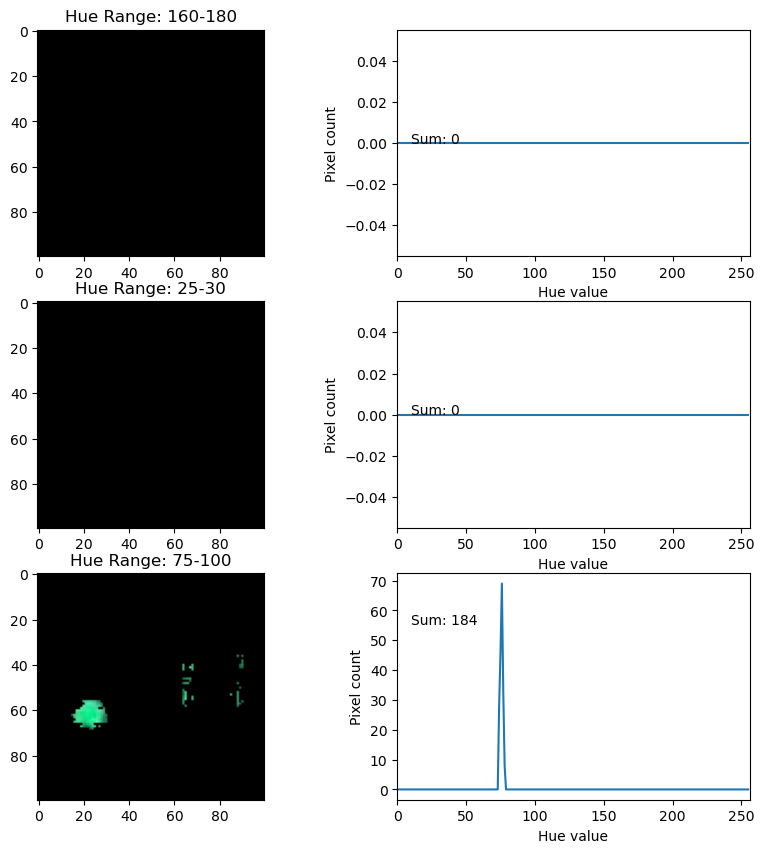

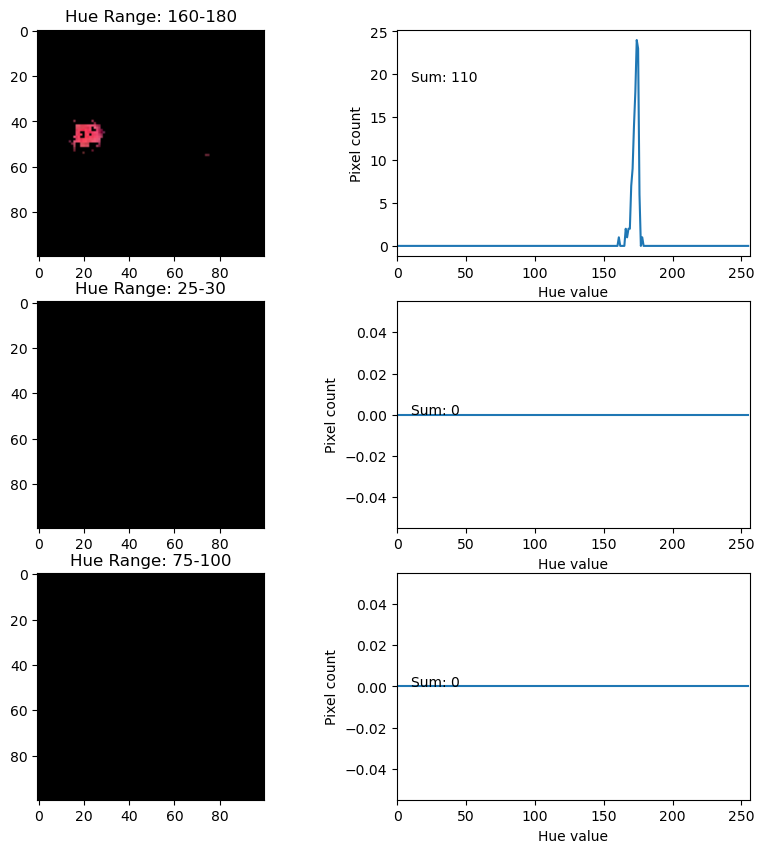

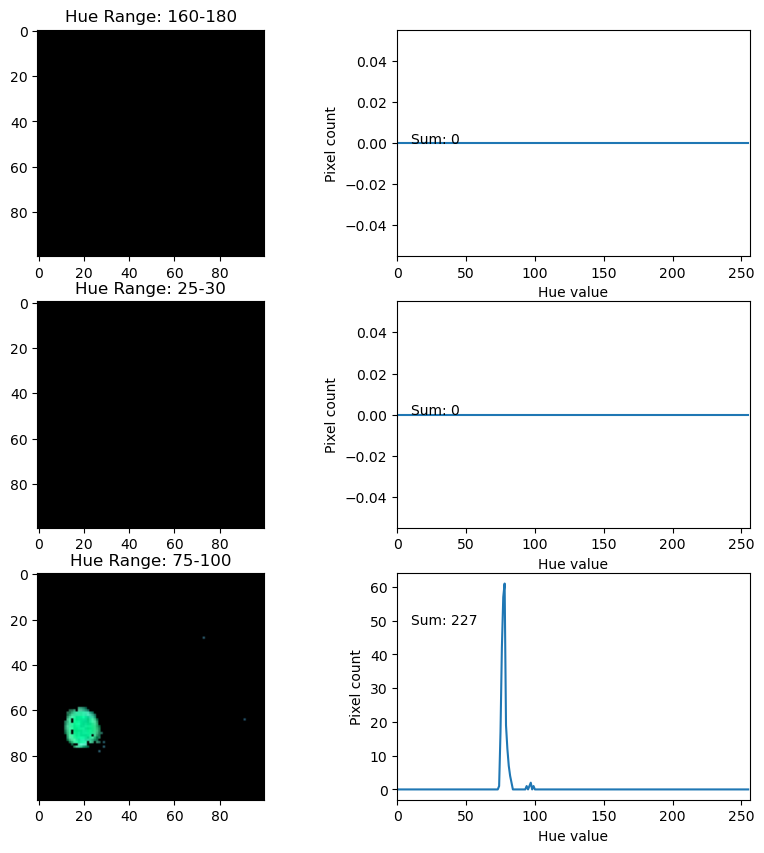

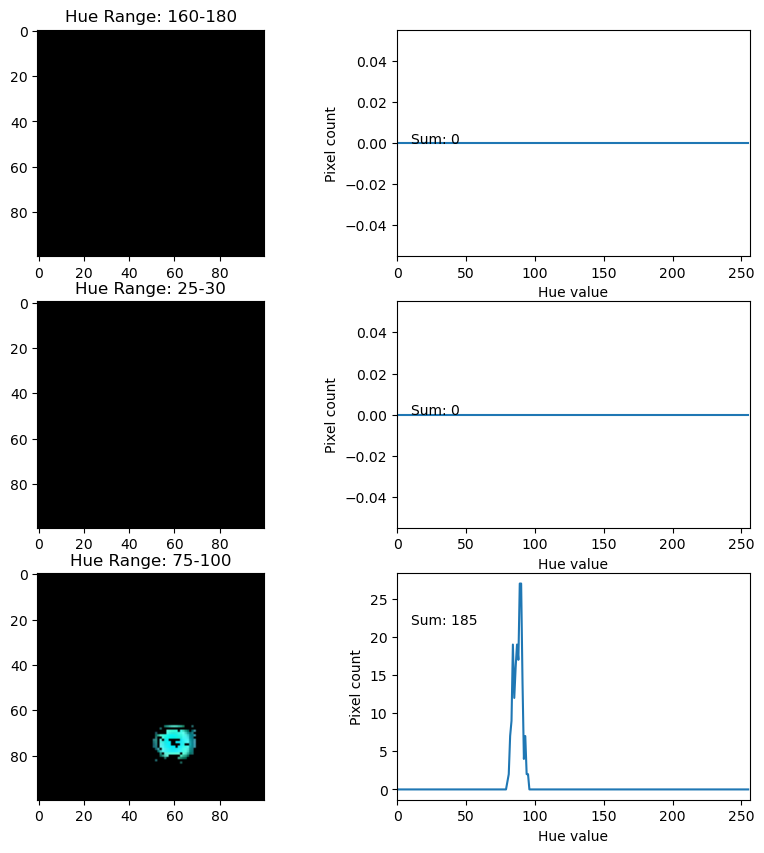

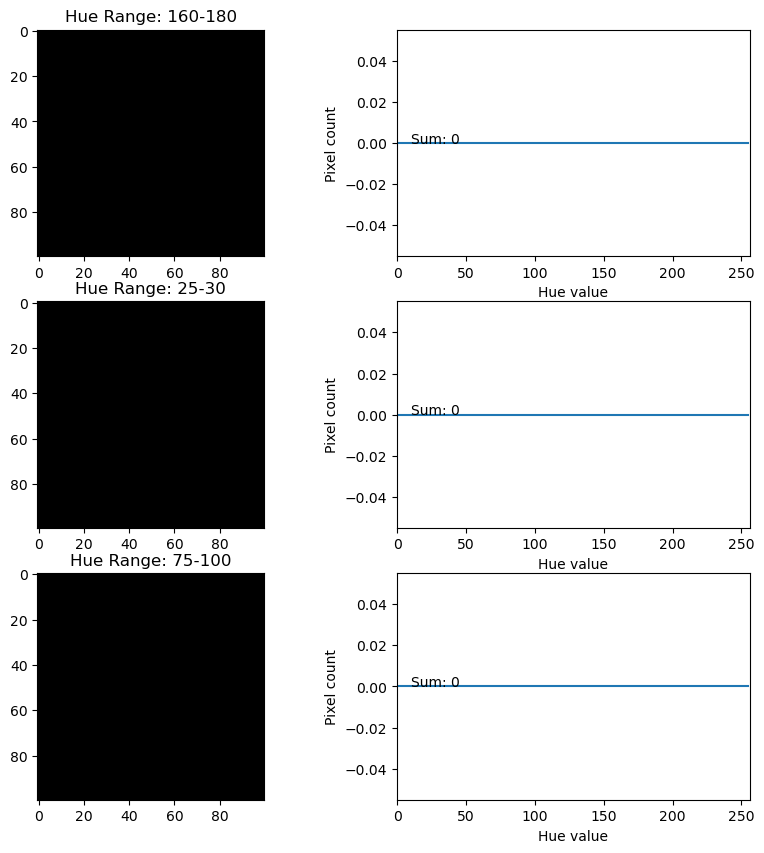

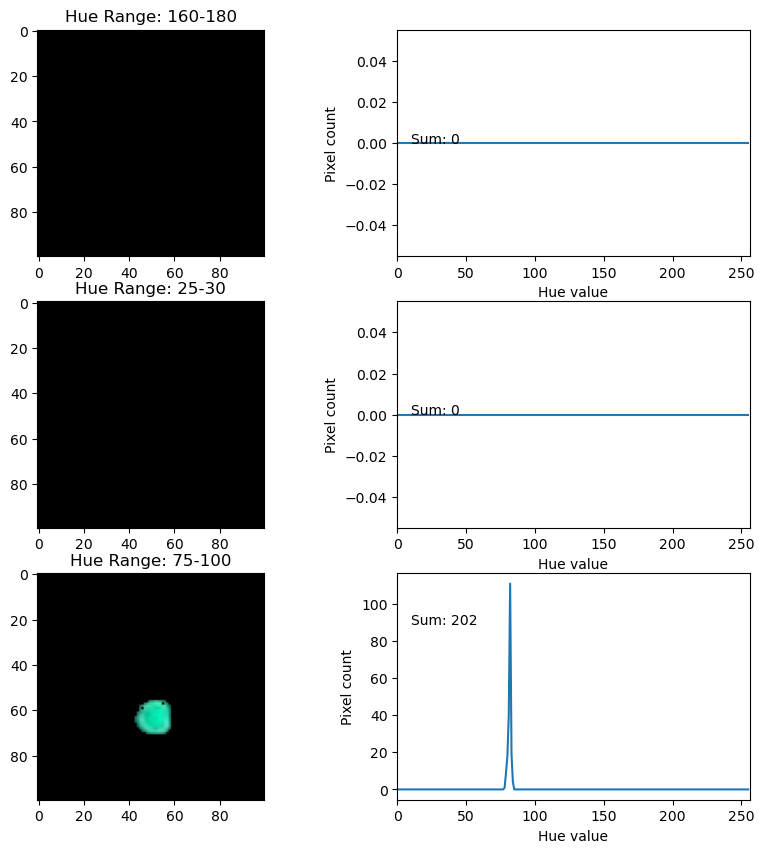

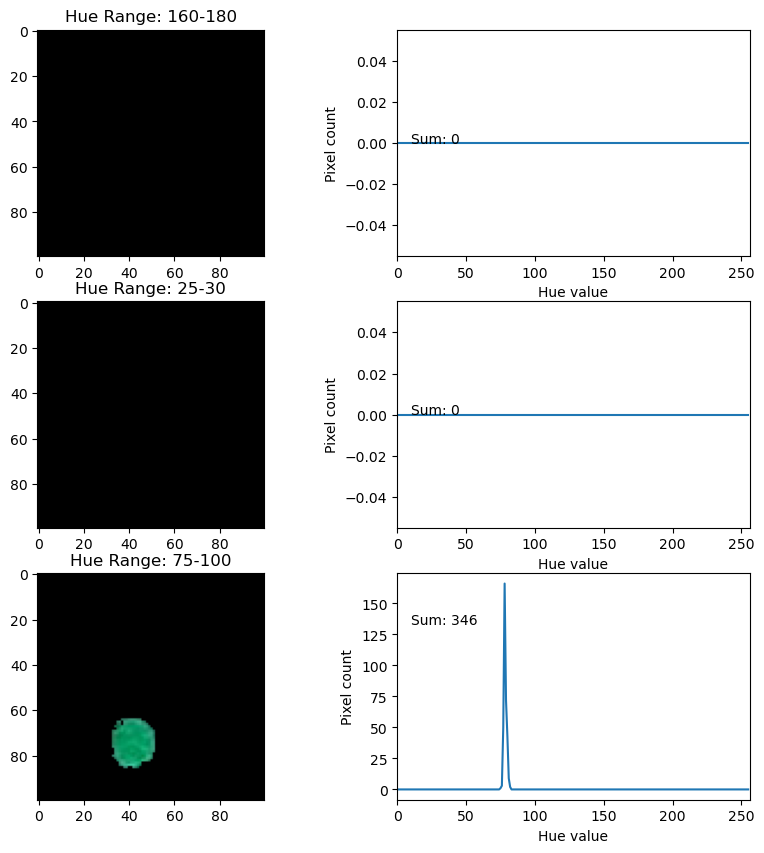

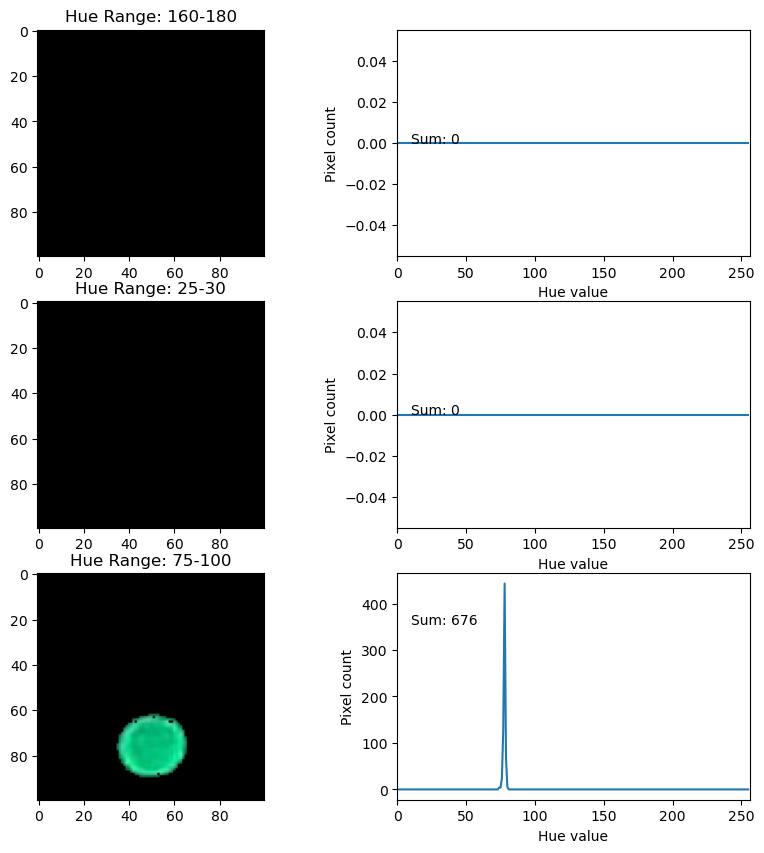

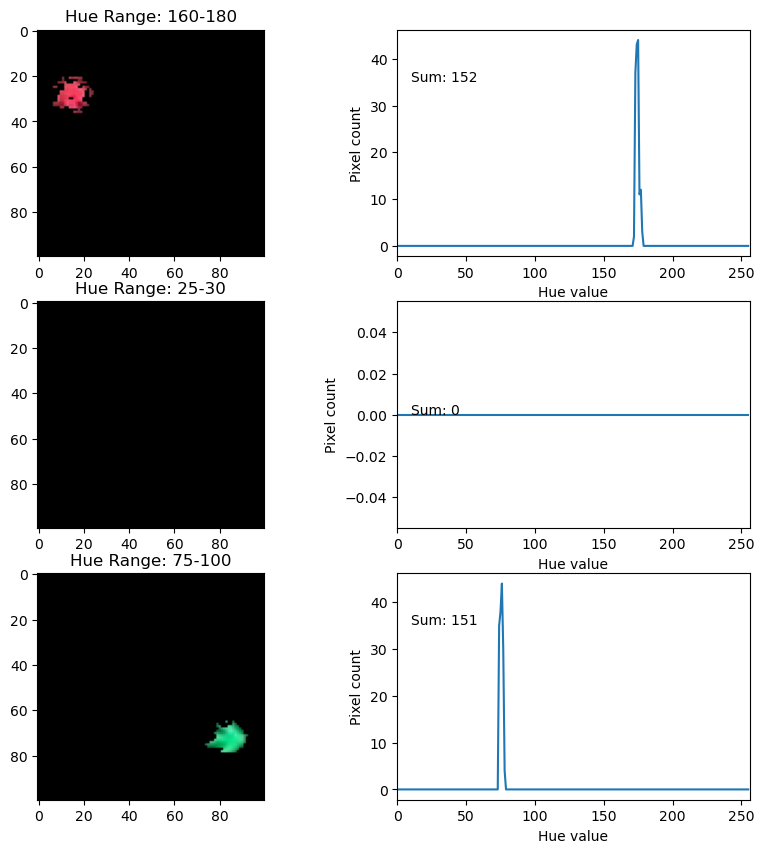

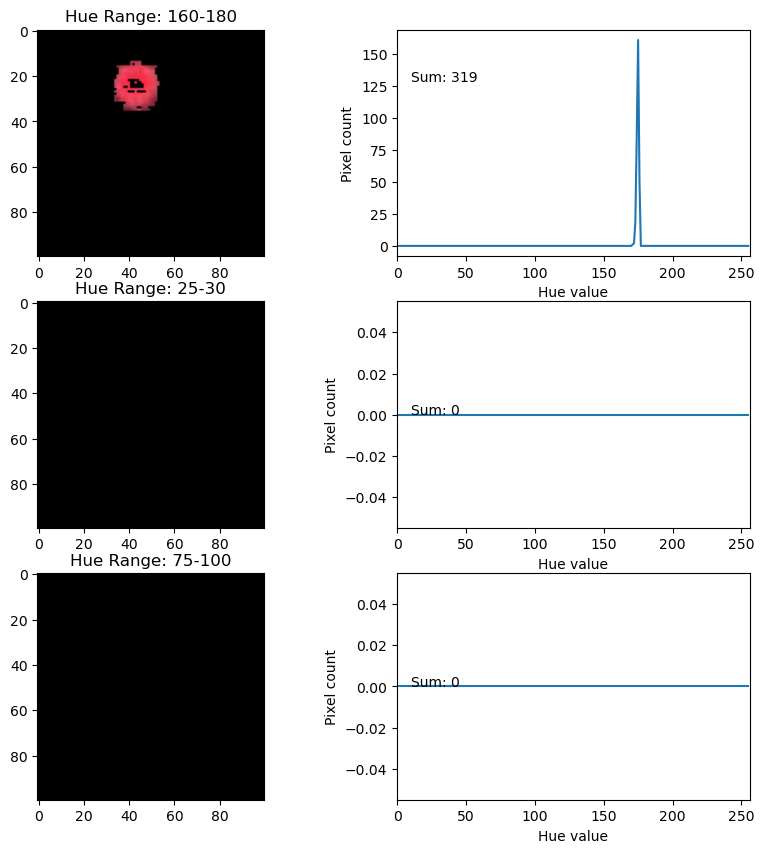

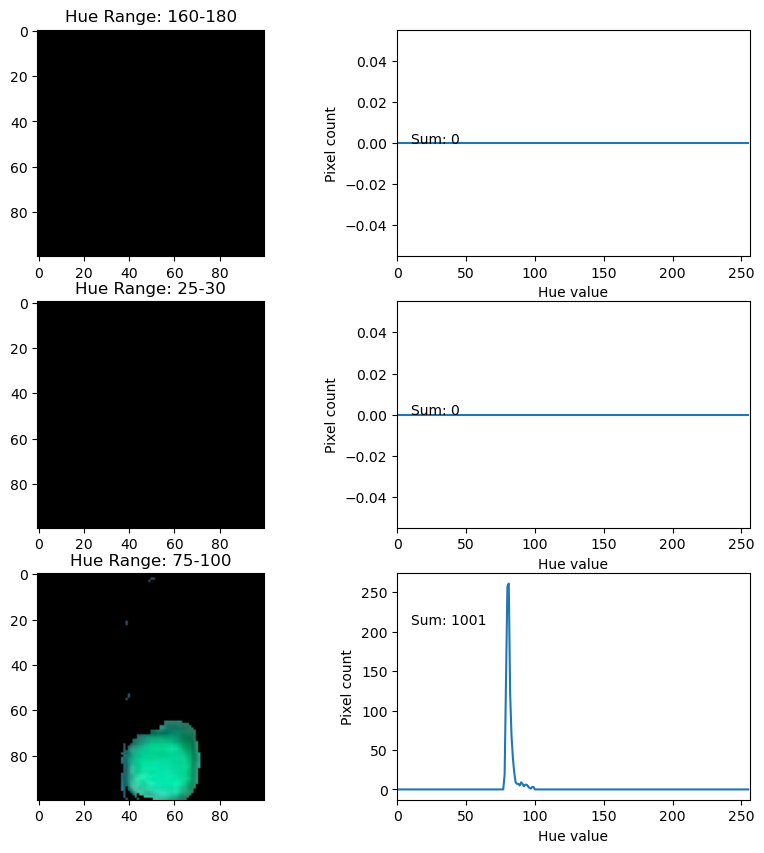

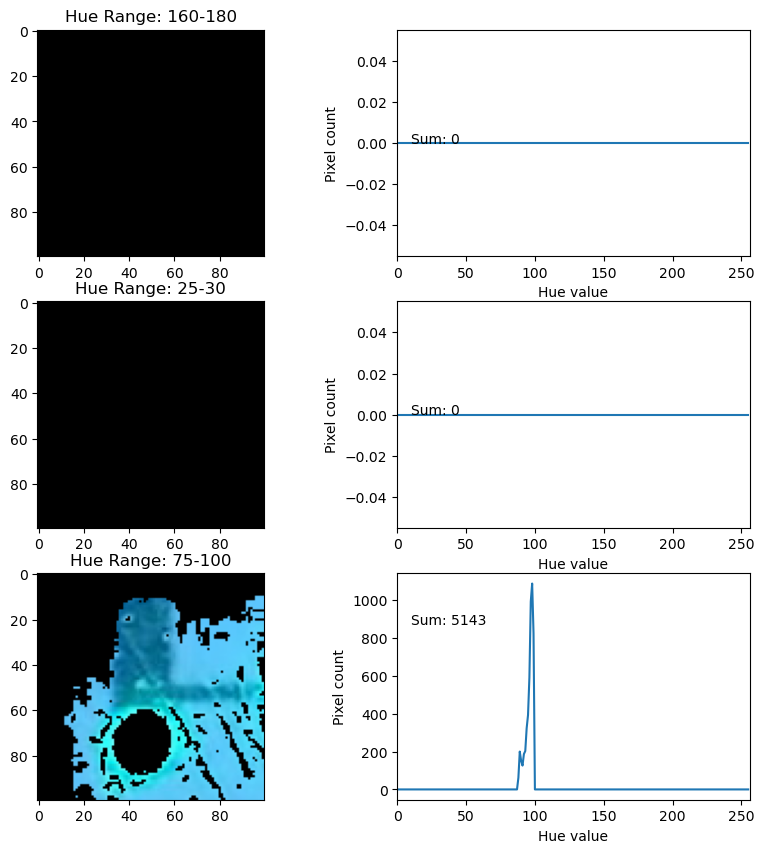

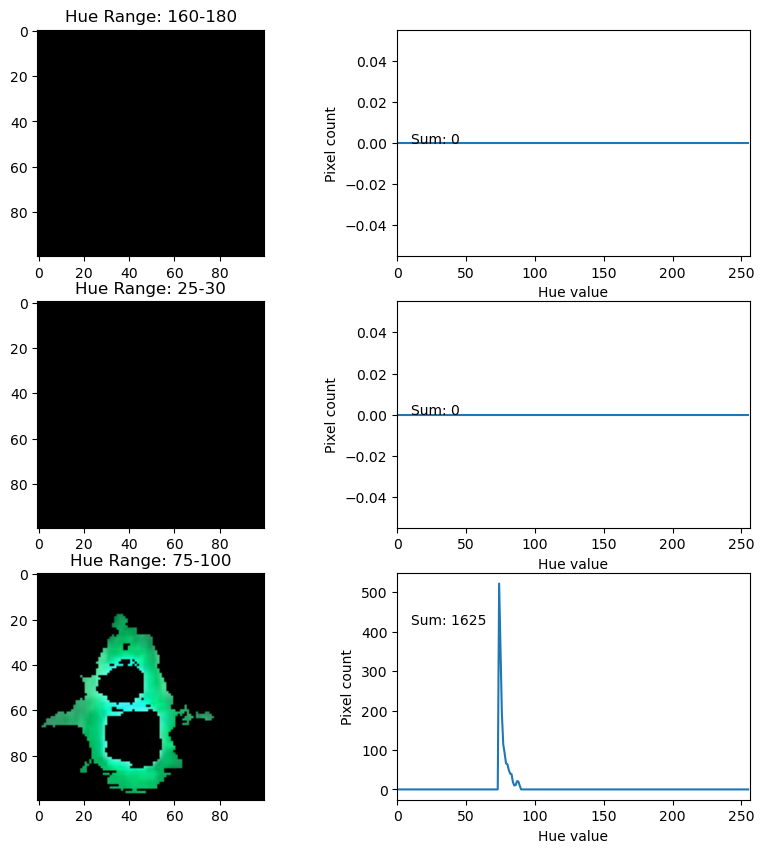

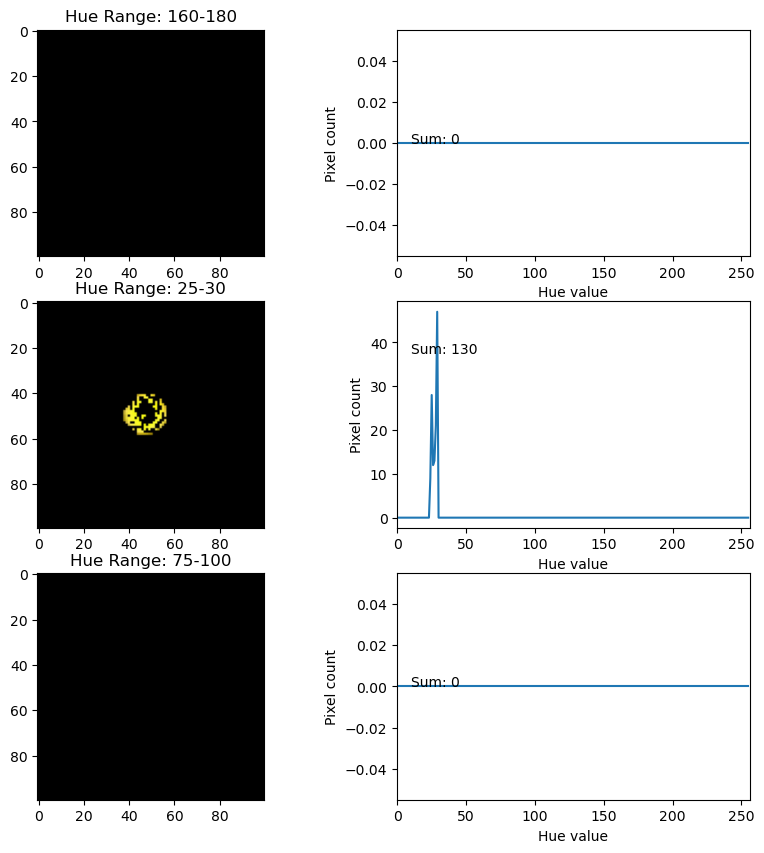

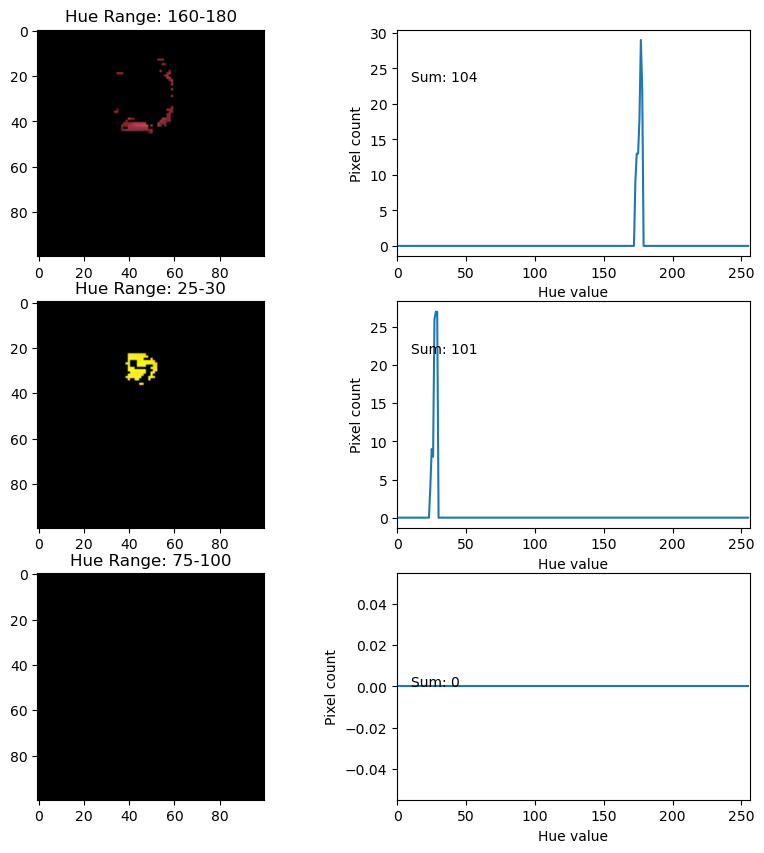

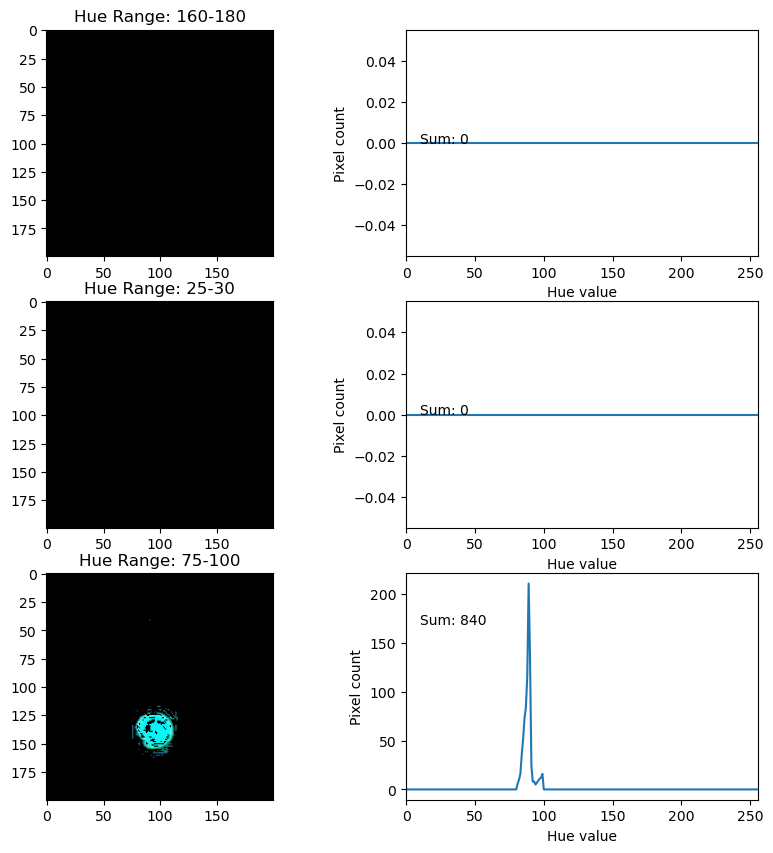

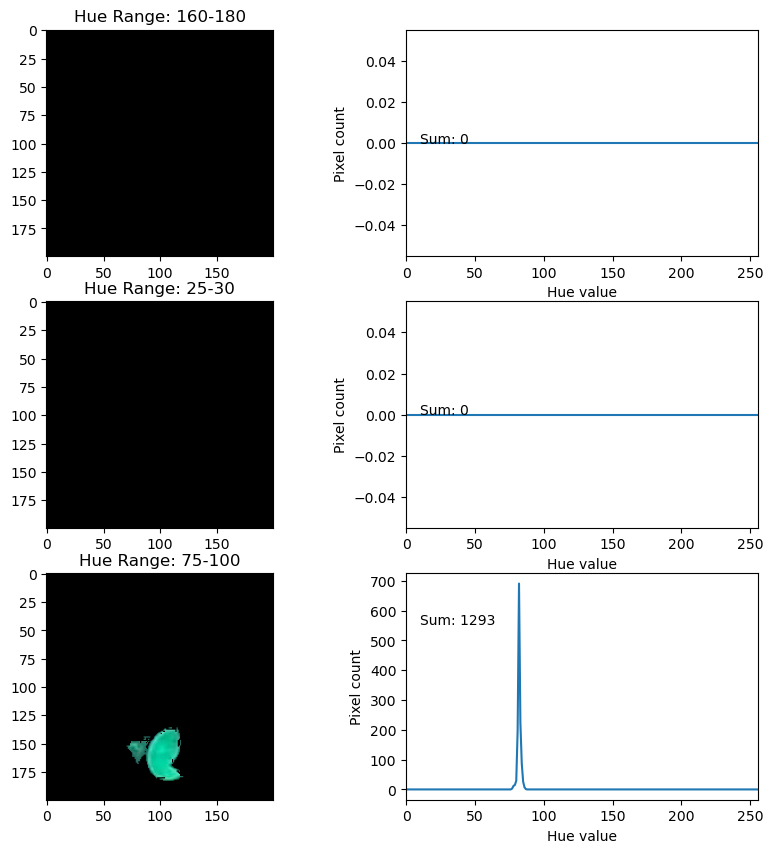

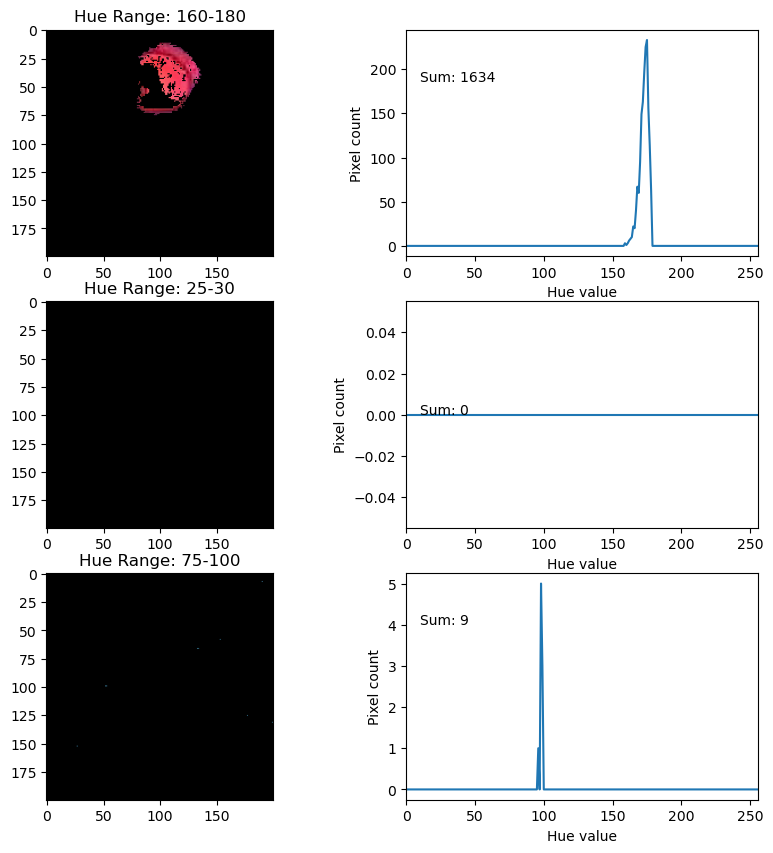

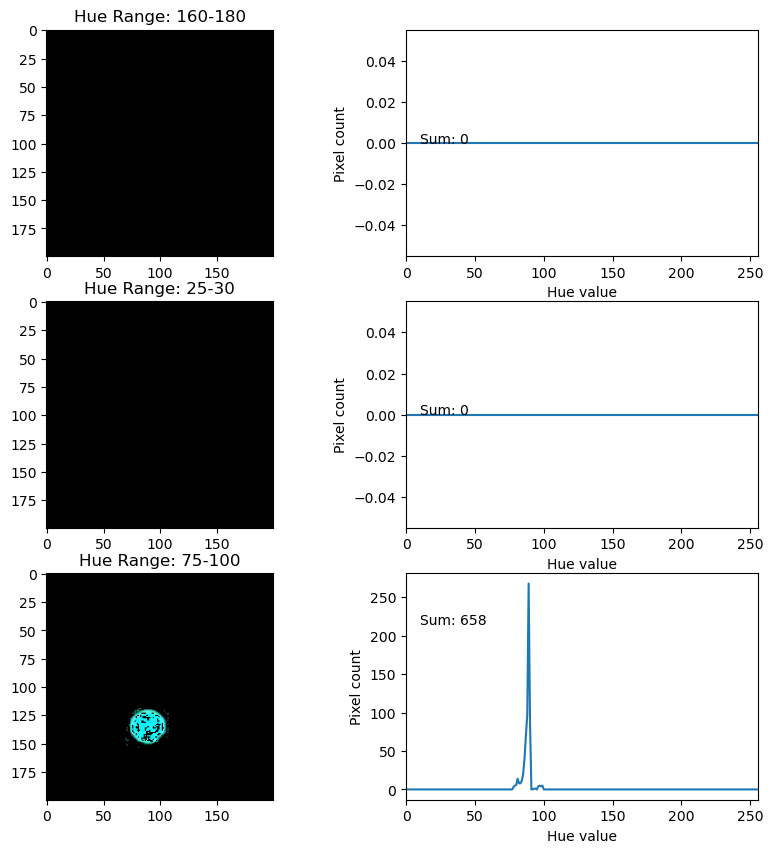

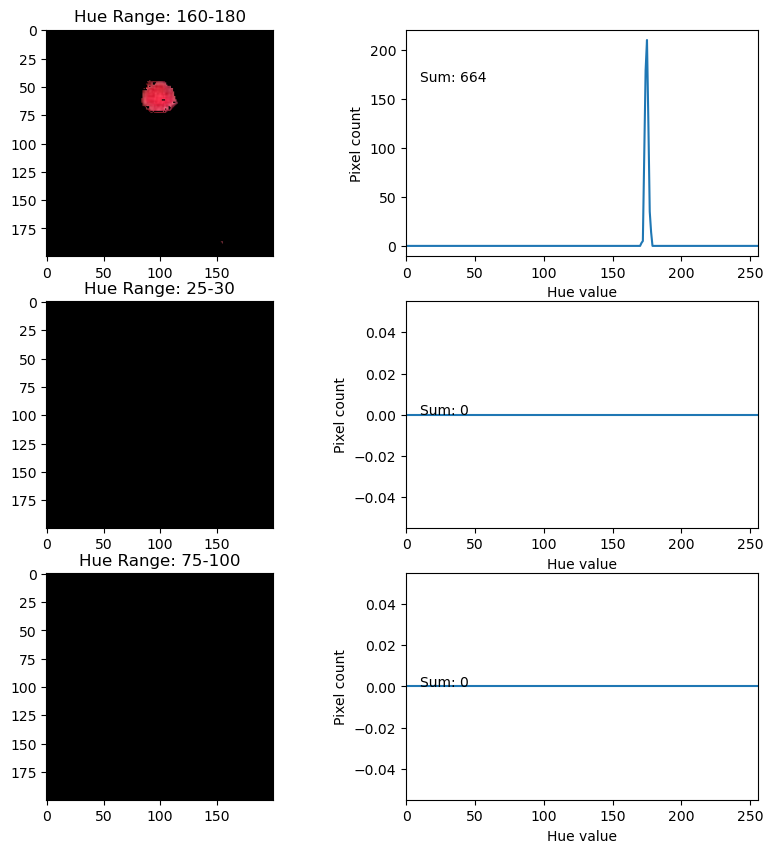

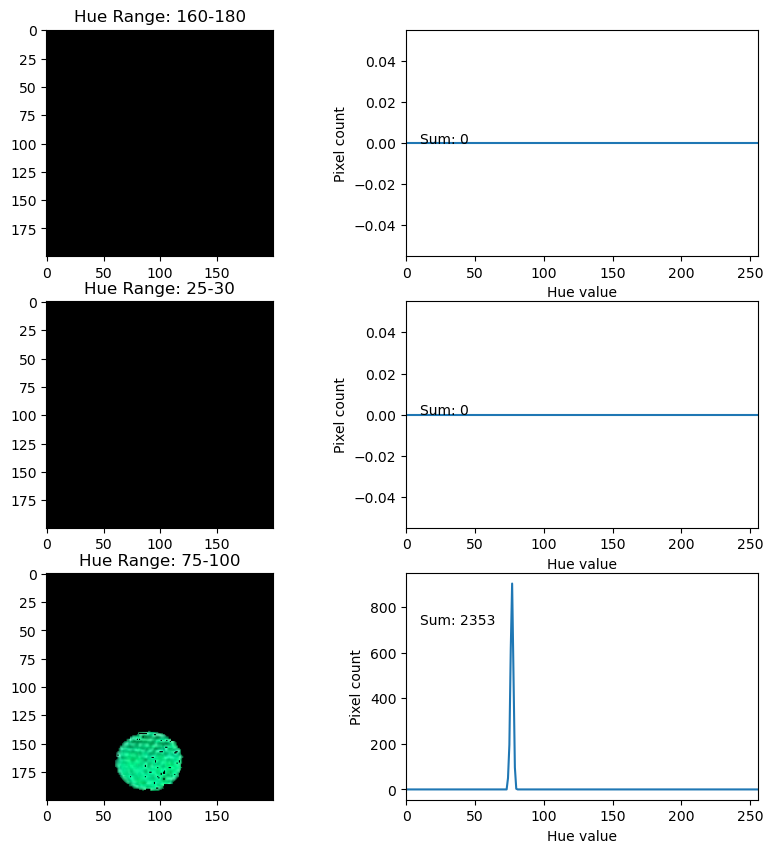

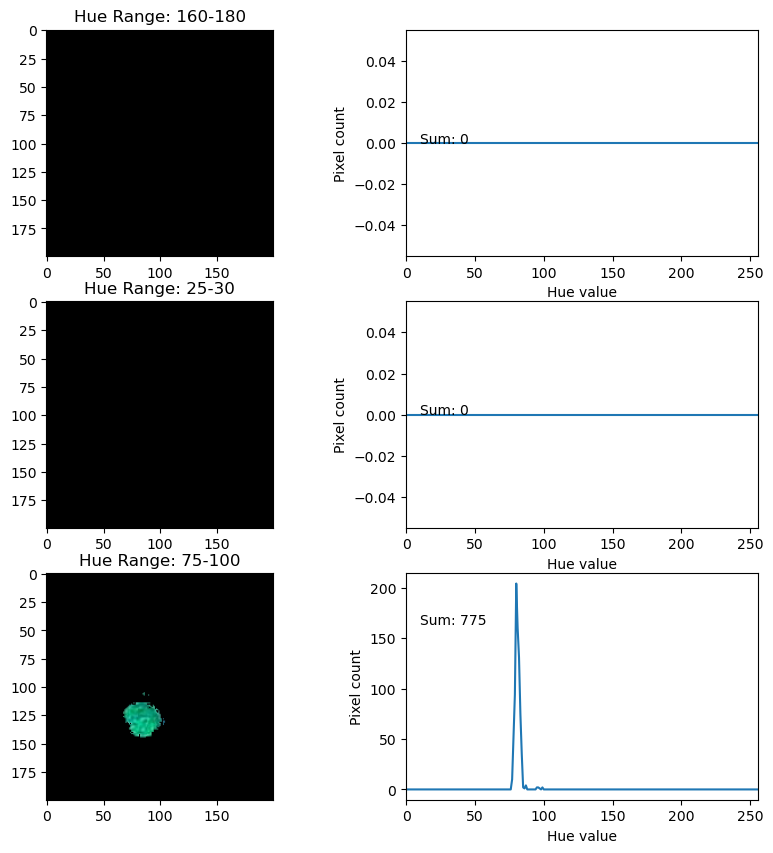

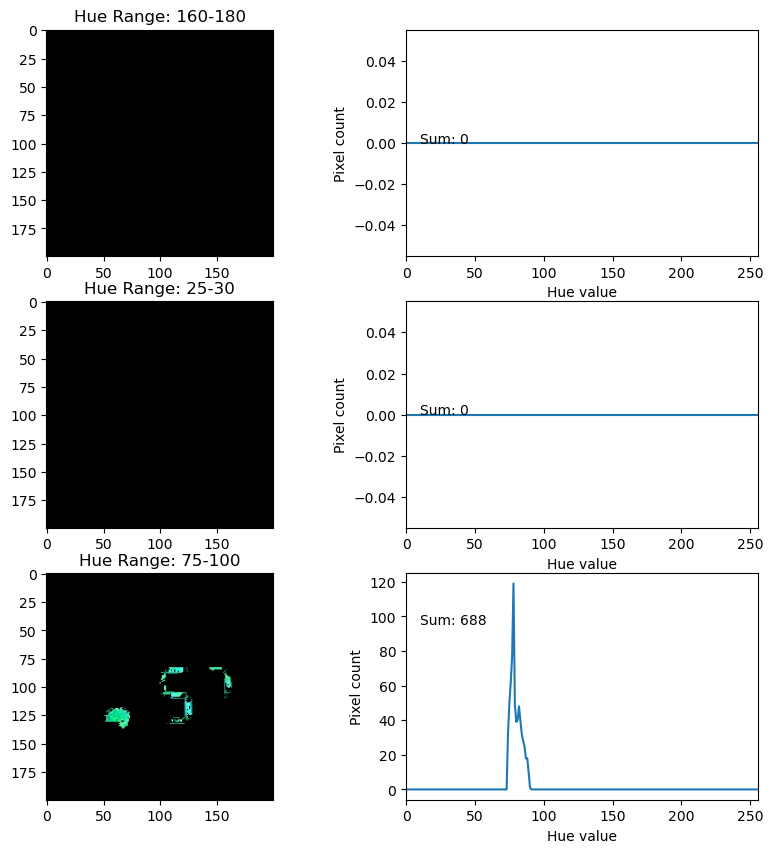

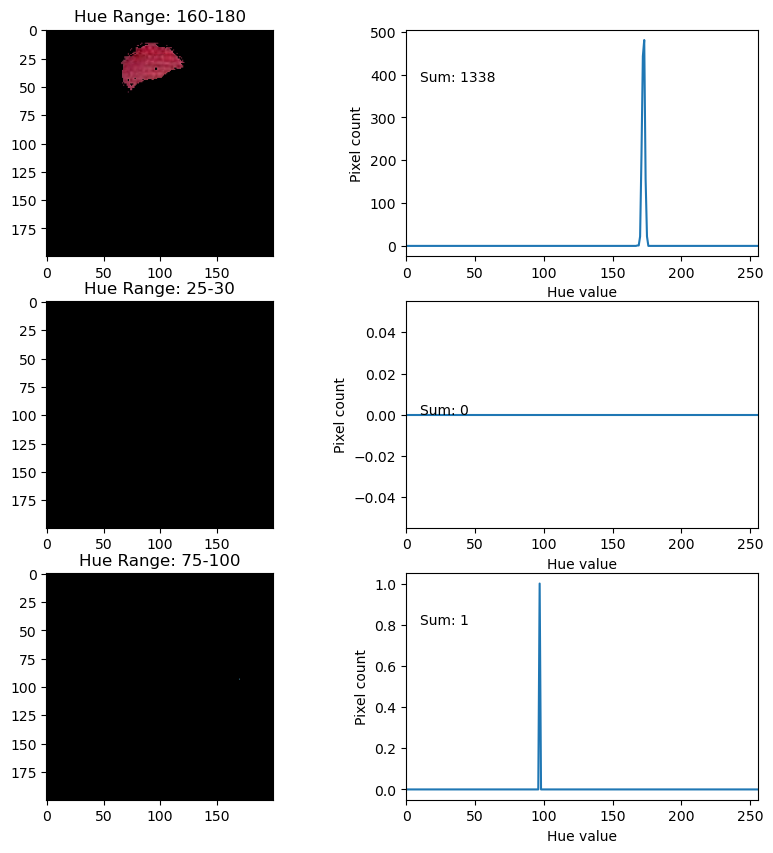

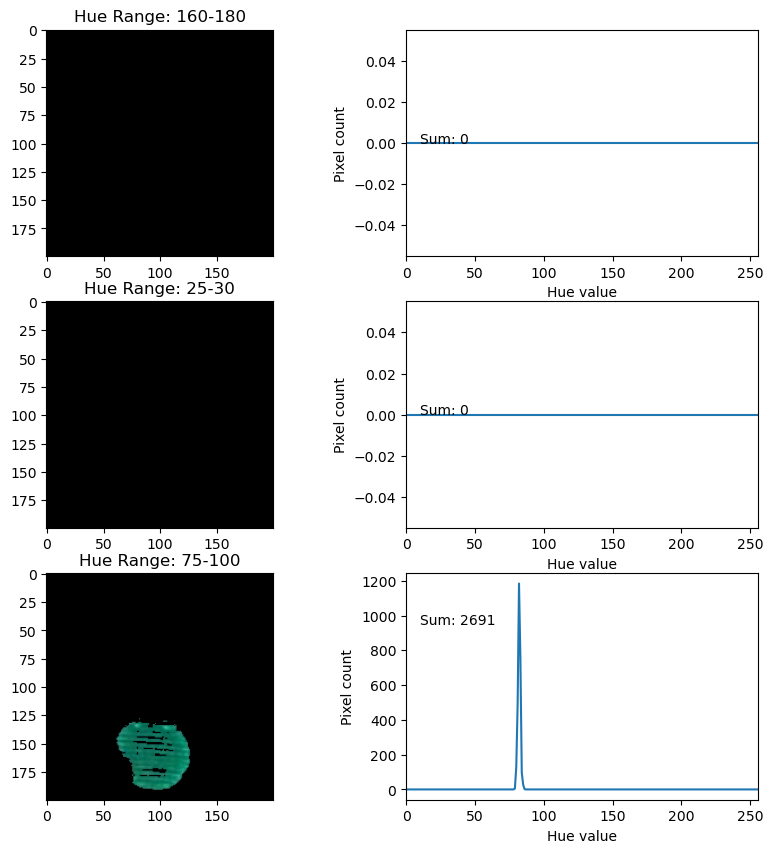

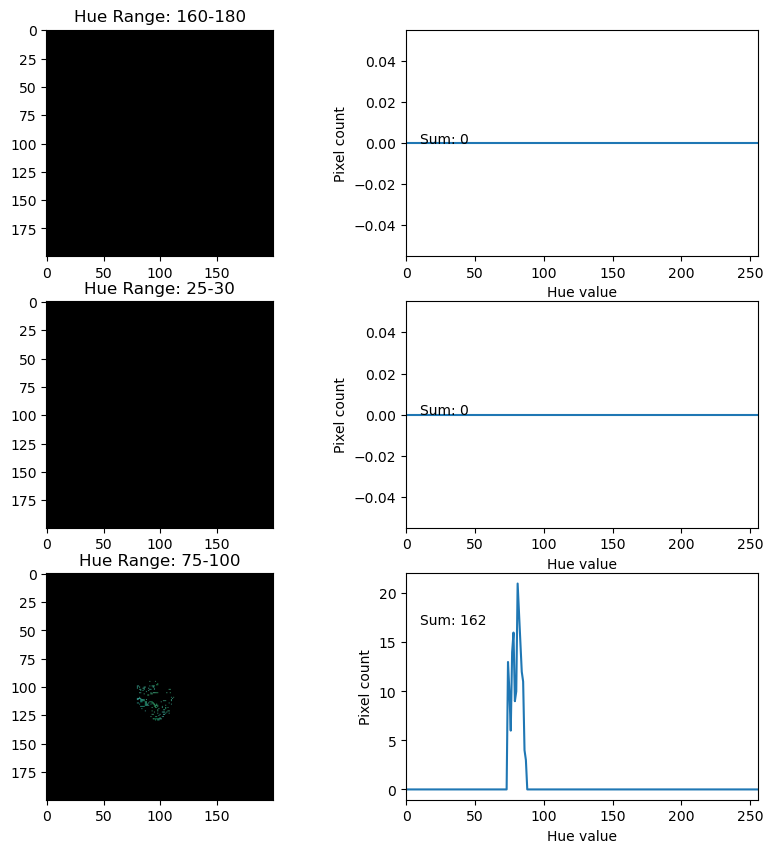

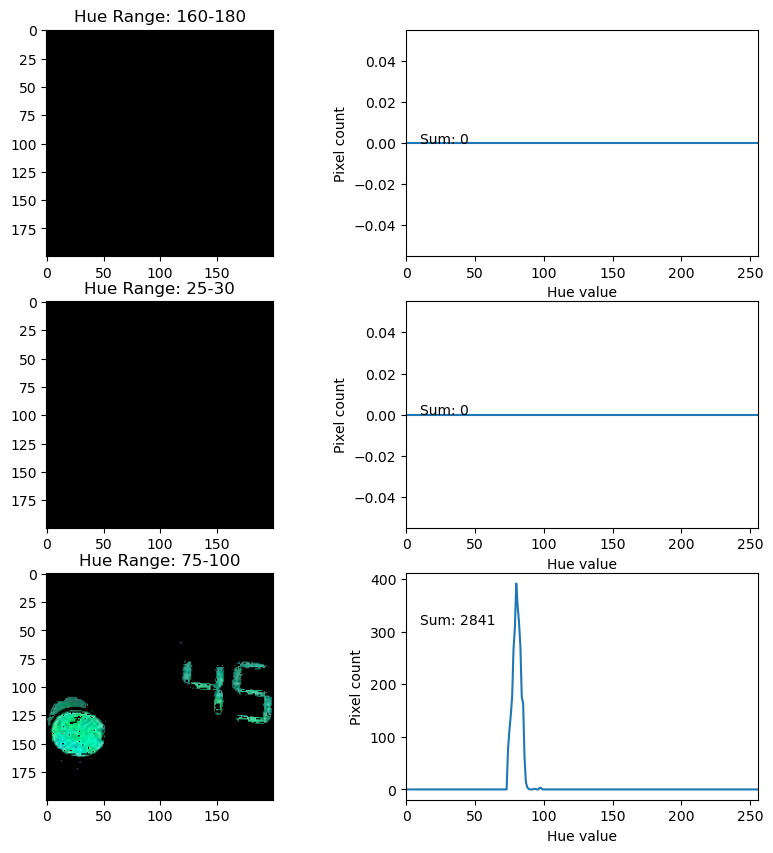

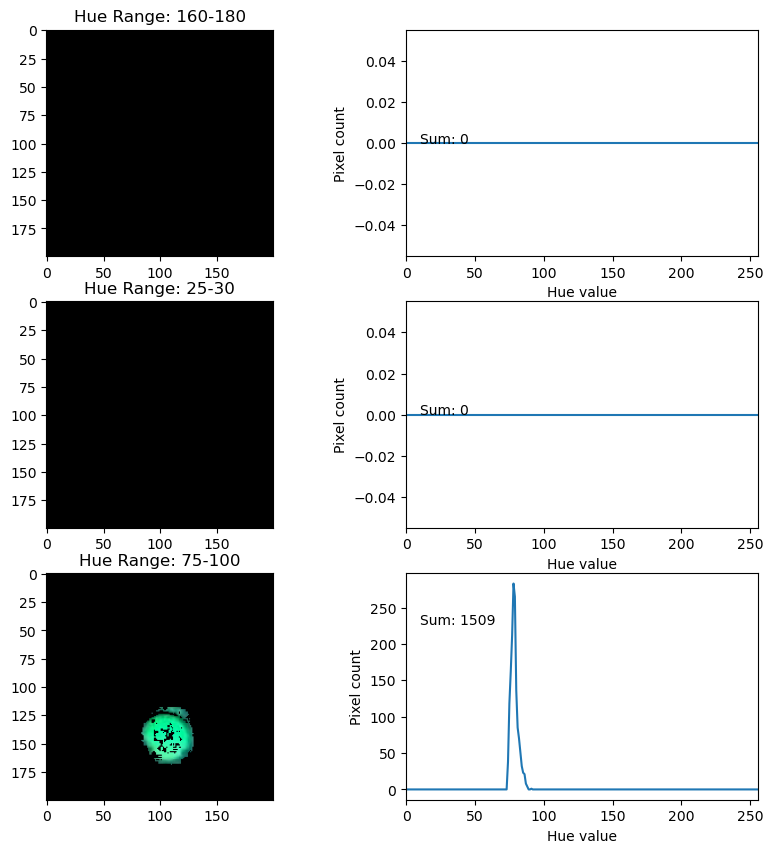

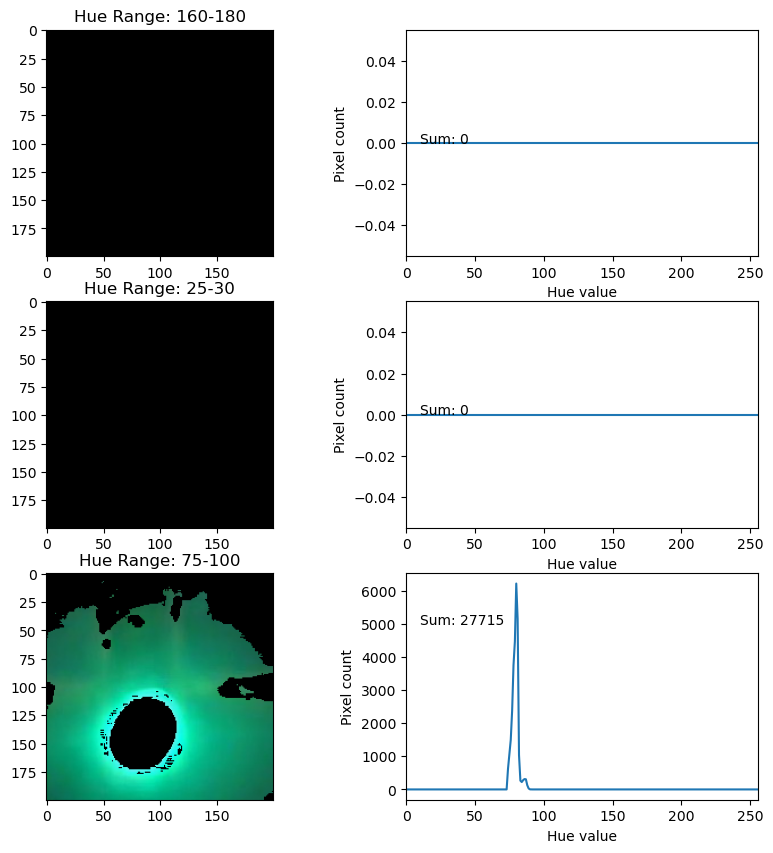

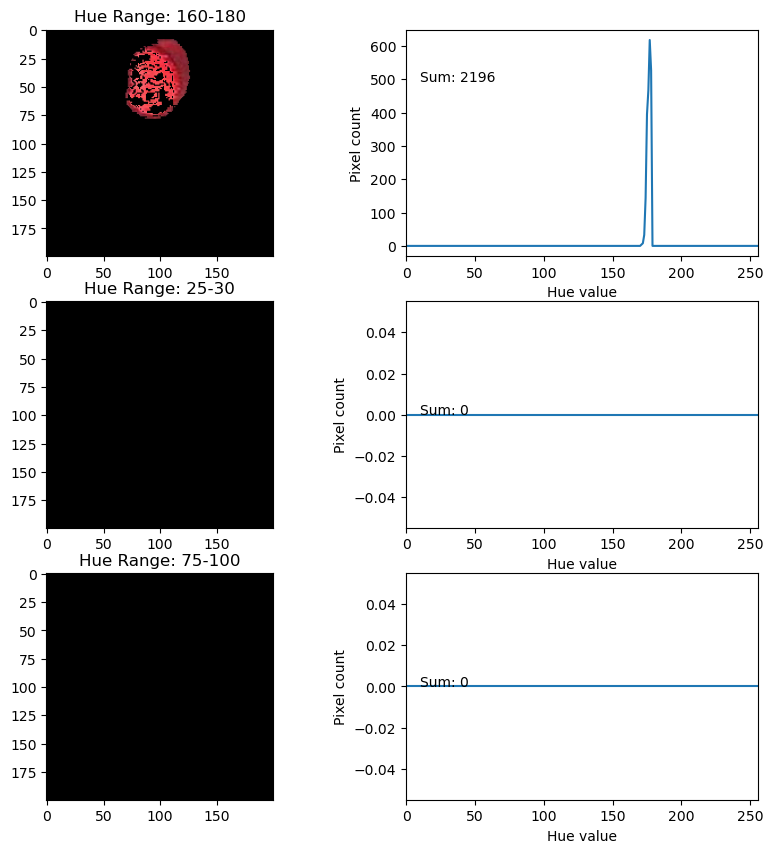

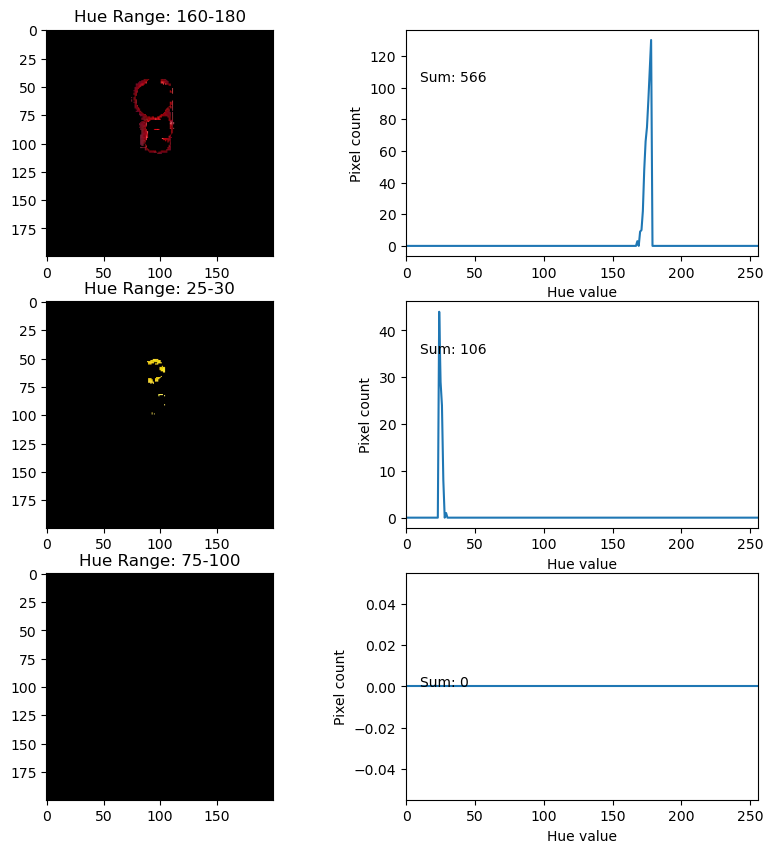

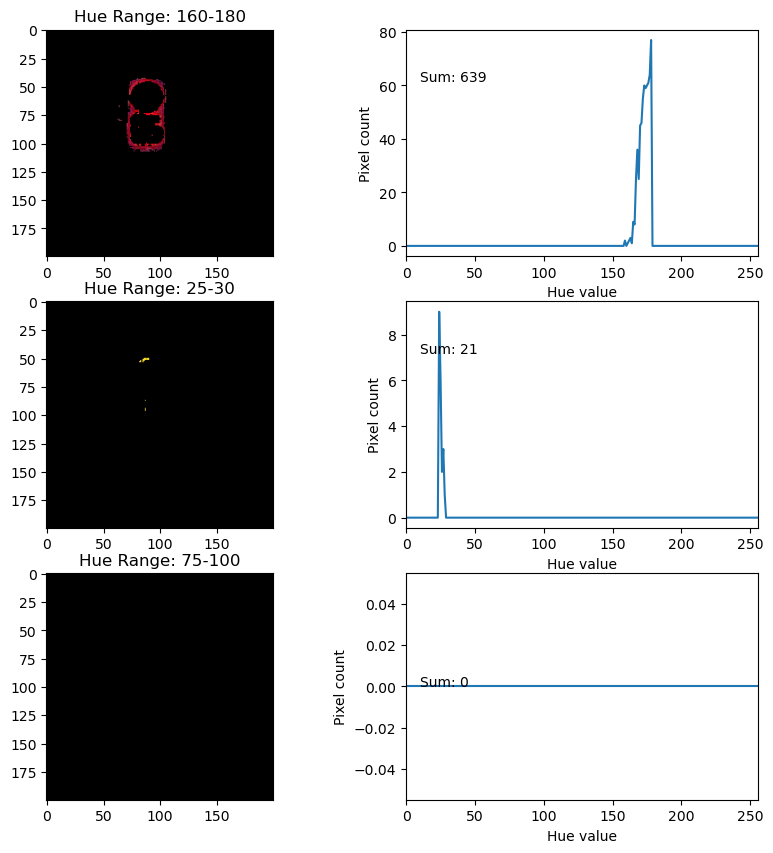

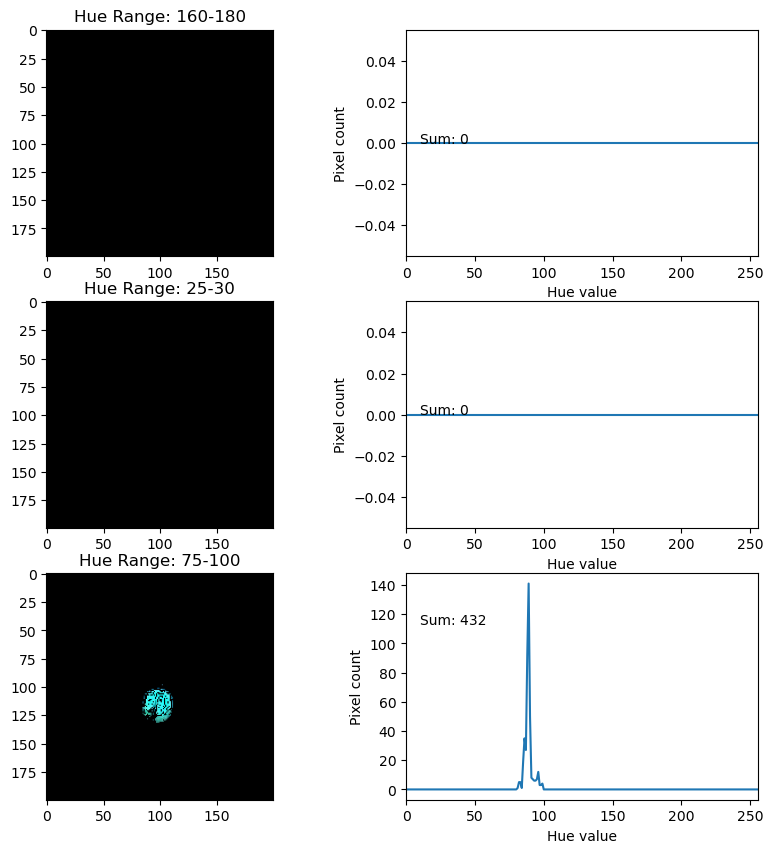

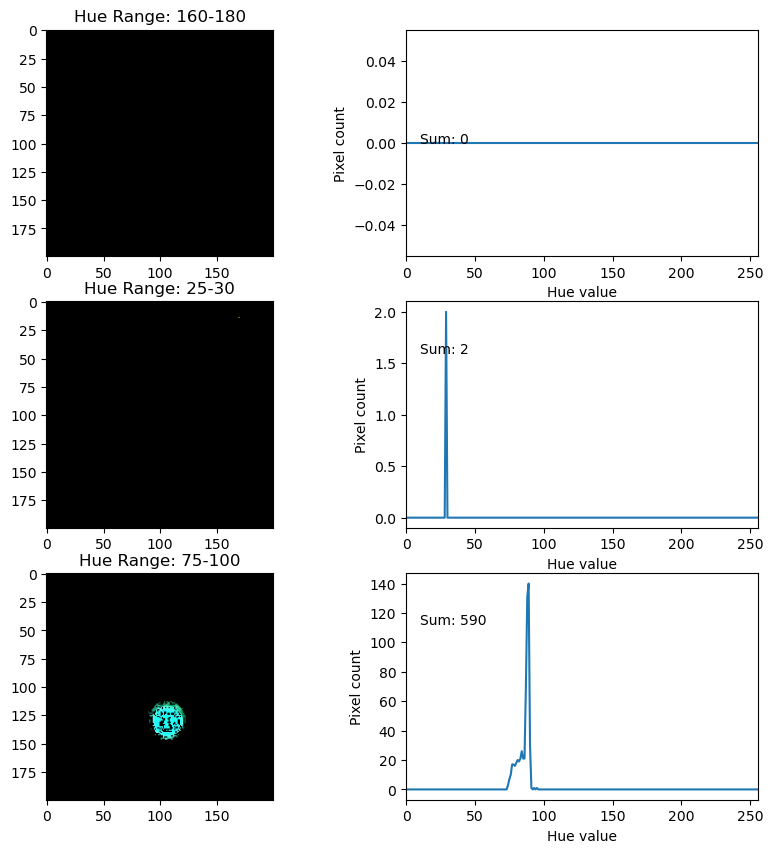

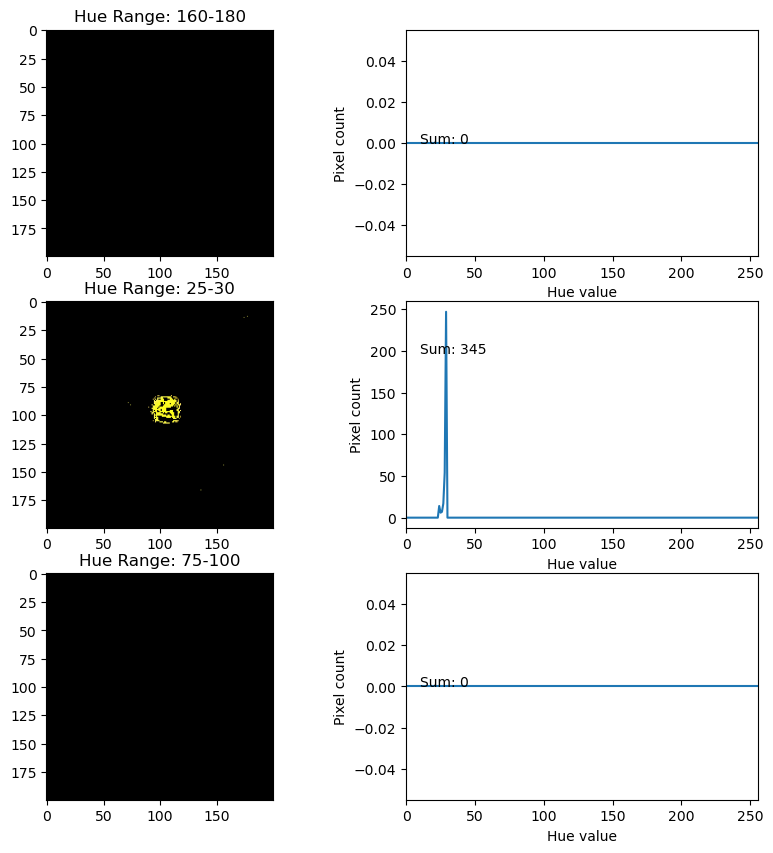

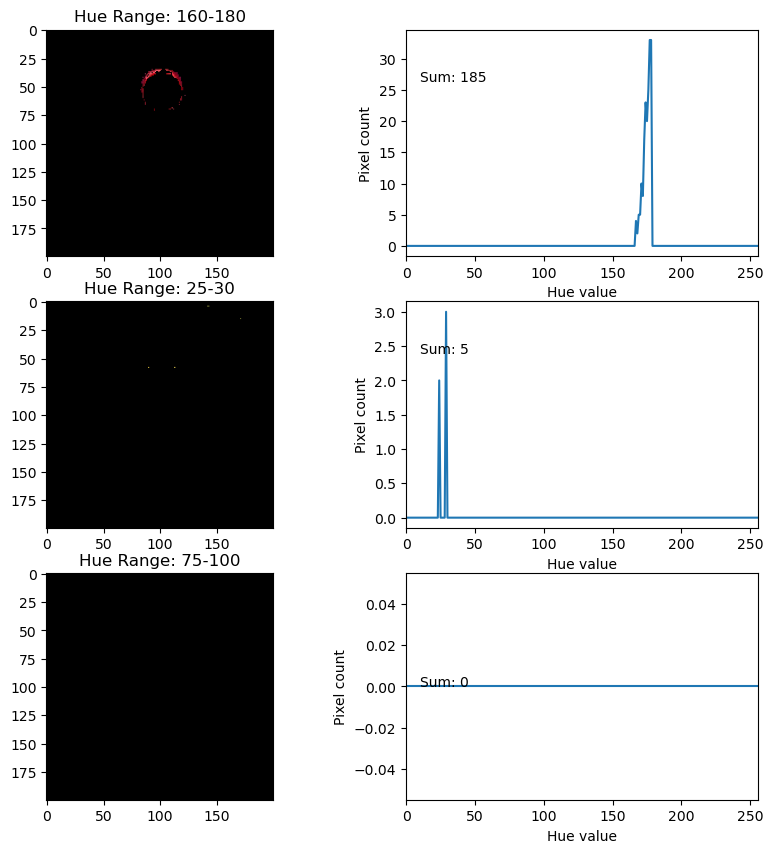

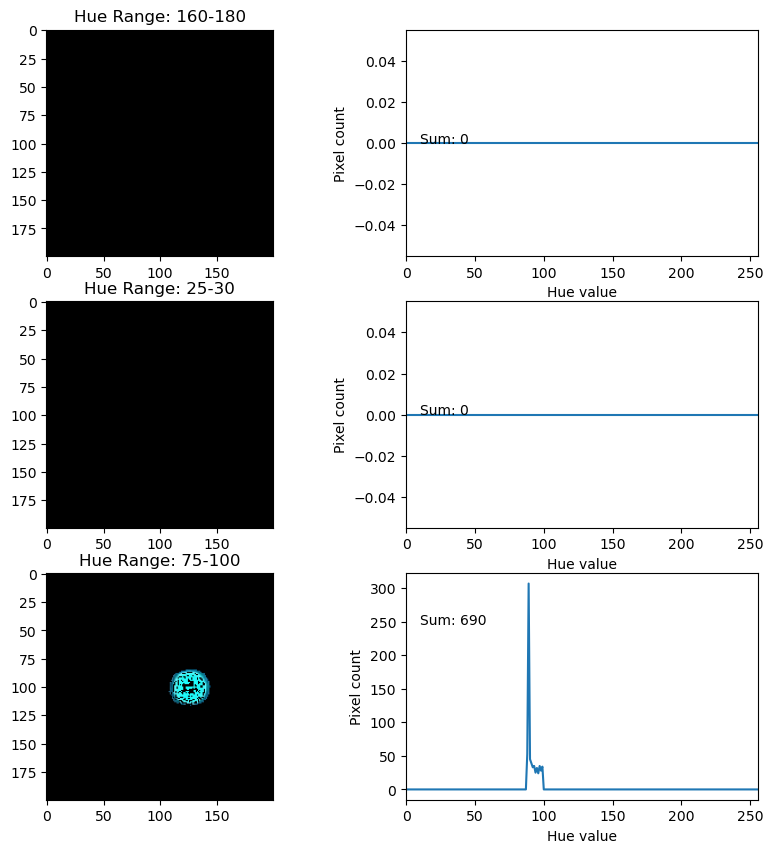

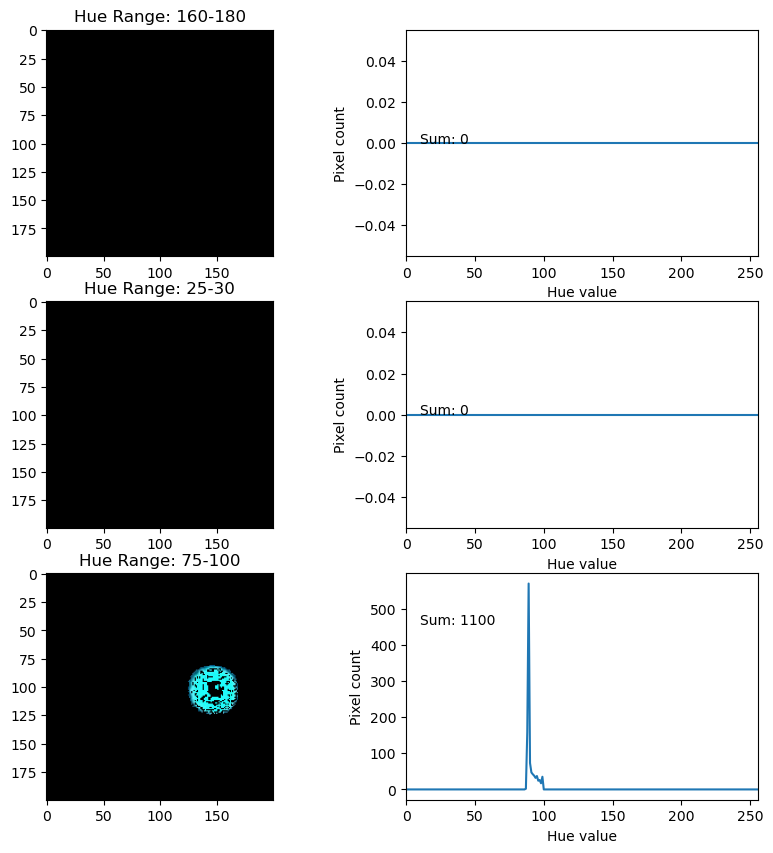

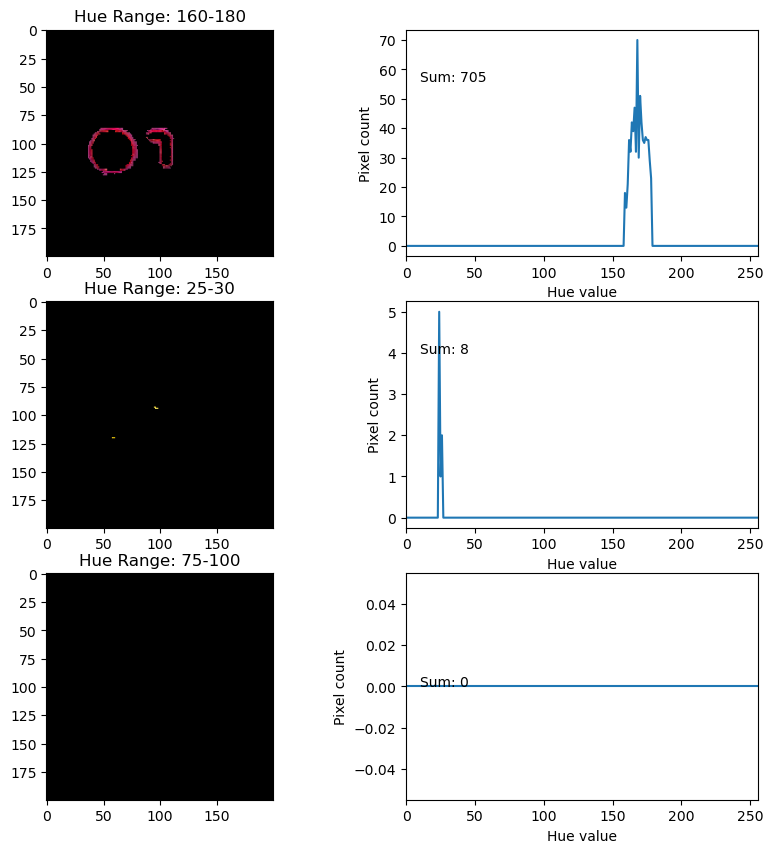

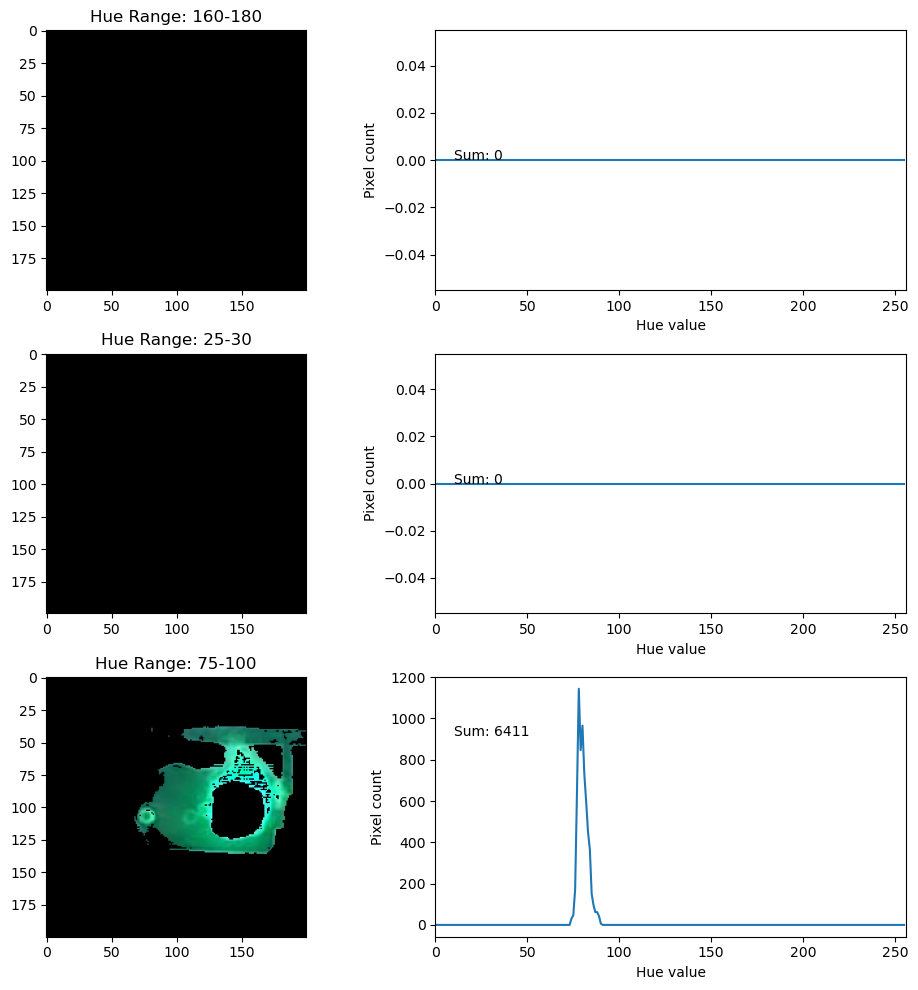

Red: ['100_01.jpg', '100_07.jpg', '100_08.jpg', '100_12.jpg', '100_20.jpg', '200_03.jpg', '200_05.jpg', '200_09.jpg', '200_15.jpg', '200_16.jpg', '200_17.jpg', '200_21.jpg', '200_24.jpg']
Yellow: ['100_02.jpg', '100_24.jpg', '200_20.jpg']
Green: ['100_03.jpg', '100_04.jpg', '100_05.jpg', '100_06.jpg', '100_09.jpg', '100_10.jpg', '100_11.jpg', '100_13.jpg', '100_14.jpg', '100_16.jpg', '100_17.jpg', '100_18.jpg', '100_21.jpg', '100_22.jpg', '100_23.jpg', '200_01.jpg', '200_02.jpg', '200_04.jpg', '200_06.jpg', '200_07.jpg', '200_08.jpg', '200_10.jpg', '200_11.jpg', '200_12.jpg', '200_13.jpg', '200_14.jpg', '200_18.jpg', '200_19.jpg', '200_22.jpg', '200_23.jpg', '200_25.jpg']
undefined: ['100_15.jpg', '100_19.jpg', '100_25.jpg']


In [5]:
colors = ["red", "yellow", "green"]
hue_ranges = [(160, 180), (25, 30), (75, 100)] 
s_threshold = 150  # Saturation threshold
v_min, v_max = 100, 255  # Value range

red_images, yellow_images, green_images, undefined_images = [], [], [], []
color_image_lists = [red_images, yellow_images, green_images]

def Classifier(img_rgb, img_hsv, hue_range, row, col):
    hue_low, hue_high = hue_range
    wellplate = np.copy(img_rgb)
    hue_mask = np.logical_and(img_hsv[:,:,0] >= hue_low, img_hsv[:,:,0] <= hue_high)
    saturation_mask = img_hsv[:,:,1] > s_threshold
    value_mask = (img_hsv[:,:,2] > v_min) & (img_hsv[:,:,2] < v_max)
    hsv_mask = hue_mask & saturation_mask & value_mask

    masked_img = wellplate[:]
    masked_img[np.logical_not(hsv_mask)] = 0
    masked_img_hsv = cv.cvtColor(masked_img, cv.COLOR_RGB2HSV)
    
    plt.subplot(3, 2, 2*row + col)
    if col == 1:
        plt.imshow(masked_img)
        plt.title(f"Hue Range: {hue_low}-{hue_high}")
    else:
        plt.xlim([0, 256])
        histogram, bin_edges = np.histogram(
            masked_img_hsv[:, :, 0], bins=256, range=(1, 256)
        )
        start, end = hue_range
        start_idx = np.digitize(start, bin_edges) - 1
        end_idx = np.digitize(end, bin_edges) - 1
        sum_value = np.sum(histogram[start_idx:end_idx+1])
        
        plt.plot(histogram)
        plt.xlabel("Hue value")
        plt.ylabel("Pixel count")
        plt.text(10, 0.8 * max(histogram), f"Sum: {sum_value}", fontsize=10)
        return sum_value
        
# Mask each HSV image
for (name_rgb, img_rgb), (name_hsv, img_hsv) in zip(images_rgb.items(), images_hsv.items()):
    sums = []
    plt.figure(figsize=(10, 10))

    for i, hue_range in enumerate(hue_ranges):
        Classifier(img_rgb, img_hsv, hue_range, i, 1)
        sums.append(Classifier(img_rgb, img_hsv, hue_range, i, 2))

    if sum(sums) != 0: # Determine whether there are unmasked colors
        max1 = np.sort(sums)[-1]
        max2 = np.sort(sums)[-2]
        if max1 > 5*max2: # The maximum value is greater than 5 times the second
            color_image_lists[np.argmax(sums)].append(name_rgb)
        else:
            undefined_images.append(name_rgb)        
    else:
        undefined_images.append(name_rgb)

plt.tight_layout()
plt.show()

print("Red:", red_images)
print("Yellow:", yellow_images)
print("Green:", green_images)
print("undefined:", undefined_images)